In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import utils

% matplotlib inline

In [18]:
# GLOBAL VARIABLES
FIELD_AGENT_COORDS = "agent_coords"
FIELD_POPULATION_SIZE = "population_size"
FIELD_TIME = "time"
FIELD_EXTINCTION_TIME = "extinction_time"

MAX_GENERATIONAL_UPDATE = 100000

In [239]:
class Stochastic_Sim(object):
    """
    Parameters: 
    -----------
    init_dist :: int array or int
        - Distribution of agents in phenotype space at time 0. 
        - if type == int, produce delta distribution with size num_init
    
    num_init :: int 
        - see init_dist parameter
    
    tau :: float
        - characteristic time scale
    
    delta :: float
        - characteristic length scale
    
    optimum_coord :: float
    gamma :: float
        - mean number of birth per period tau
    
    epsilon :: float
        - correction to birth rate. 
        - actual mean birth per tau = gamma - epsilon * delta ** 2 * (coord - optimum_coord) ** 2
        
    kappa :: float
        - mean number of death per unit population per unit tau
    
    mutation_rate :: float
        - mean number of mutation event per unit tau
    
    max_num_update :: int
        - maximum number of updates made regardless if max_time is reached
    
    max_time :: float
        - the termination time for the simulation
    
    walk_generator :: void -> random number of random displacement distribution
    
    population_change_tolerance :: float (betwee 0 and 1)
        - the percentage change of the population before a complete refreshment
          of all exponential clocks is needed
    """
    def __init__(self, init_dist=None, num_init=500,
                 tau=0.01, delta=0.01, optimum_coord=0.0, 
                 gamma=None, kappa=None, epsilon=None, mutation_rate=None,
                 max_num_update=1000, max_time=None,
                 walk_generator=None, 
                 population_change_tolerance=0.05):
        self.gamma = gamma
        self.kappa = kappa
        self.epsilon = epsilon
        self.optimum_coord = optimum_coord
        self.mutation_rate = mutation_rate / tau
        self.tau = tau
        self.delta = delta
        self.walk_generator = walk_generator
        self.population_change_tolerance = population_change_tolerance
        self.max_num_update = max_num_update
        if not max_time:
            self.max_time = self.max_num_update * self.tau
        else:
            self.max_time = max_time
        
        self.num_init = num_init
        if type(init_dist) not in [np.ndarray, list]:
            # initialise a delta distributed initial population of size = init_dist
            self.init_dist = np.zeros(self.num_init) 
        else:
            # ignore num_init if the distribution itself is specified
            self.init_dist = init_dist 
            
        self.realisations = []
    
    def realise(self):
        # Initialise the population
        current_agents = self.init_dist
        
        # Initialise various records
        agents_n = [current_agents]
        time_n = [0]
        
        # Looping variables
        time = 0
        generation = 0
        while time < self.max_time and generation < self.max_num_update:
            population_size = len(current_agents)
            # break out of the loop if the population has gone extinct. 
            if population_size == 0:
                print("Extinction at generation: time %s (generation %i)" % (time, generation))
                break
            # break out of loop if the max number of generation is exceeded
            generation += 1
            if generation > self.max_num_update and time < self.max_time:
                print("WARNING: Number of updates exceeded before max_time is reached.")
            
            # rates
            walk_rate = np.ones(population_size) * (1.0 / self.tau) * self.mutation_rate
            death_rate = np.ones(population_size) * (1.0 / self.tau) * self.kappa * population_size
            birth_rate = np.array([self.compute_birth_rate(coord)
                                   for coord in current_agents])
            
            # exponential clocks
            walk_clocks = -1.0 / death_rate * np.log(np.random.rand(population_size))
            death_clocks = -1.0 / death_rate * np.log(np.random.rand(population_size))
            birth_clocks = -1.0 / birth_rate * np.log(np.random.rand(population_size))
            
            agent_record = zip(current_agents, birth_clocks, death_clocks, walk_clocks)
            try:
                agent_record = sorted(agent_record, key = lambda x: min(x[1:]), reverse=True)
            except:
                print agent_record
            
            num_birth = 0
            num_death = 0
            num_walk = 0
            
            num_change = 0
            percent_change = 0.0
            counter = 0
            delta_t = 0
            while percent_change < self.population_change_tolerance and delta_t < self.tau:
                record = agent_record.pop()
                coord, b, d, w = record
                t_inc = min([b, d, w])
                delta_t += t_inc
                if t_inc == b: # birth
                    new_birth_rate = self.compute_birth_rate(coord)
                    new_b1, new_b2 = -self.tau / self.compute_birth_rate(coord) * np.log(np.random.rand(2))
                    new_d1, new_d2 = -self.tau / (self.kappa * population_size)  * np.log(np.random.rand(2))
                    new_w1, new_w2 = -self.tau / self.mutation_rate * np.log(np.random.rand(2)) 
                    insert_record((coord, new_b1, new_d1, new_w1), agent_record)
                    insert_record((coord, new_b2, new_d2, new_w2), agent_record)
                    num_birth += 1
                elif t_inc == d: # death
                    num_death += 1
                elif t_inc == w:
                    new_coord = coord + self.walk_generator()
                    new_b = -self.tau / self.compute_birth_rate(new_coord) * np.log(np.random.rand())
                    new_d = -self.tau / (self.kappa * population_size)  * np.log(np.random.rand())
                    new_w = -self.tau / self.mutation_rate * np.log(np.random.rand()) 
                    new_record = (new_coord, new_b, new_d, new_w)
                    insert_record(new_record, agent_record)
                    num_walk += 1
                else:
                    raise RunTimeError
                time += t_inc
                num_change = num_birth - num_death
                percent_change = np.abs(float(num_change))/ population_size
                # break this loop if there is too many updates already
                counter += 1
                if counter > MAX_GENERATIONAL_UPDATE:
                    print("WARNING: Maximum number of updates per generation (%i) exceeded" % MAX_GENERATIONAL_UPDATE)
                    break
                if population_size + num_change <= 0:
                    print("Extinction at generation: time %s (generation %i)" % (time, generation))
                    break
            current_agents = [agent[0] for agent in agent_record]
            agents_n.append(current_agents)
            time_n.append(time)
        self.realisations.append({FIELD_AGENT_COORDS:agents_n, FIELD_TIME:time_n})
        print time_n[-1], generation, time
        return agents_n
    
    def add_realisation(self, n):
        for i in range(n):
            np.random.seed(int(time.time()))
            self.realise()
        return  
        
    def compute_birth_rate(self, coord):
        result = (1.0 / self.tau) * \
                 (self.gamma - self.delta**2 * self.epsilon * (coord - self.optimum_coord) ** 2)
        if result <= 0:
            return np.inf
        return result

In [235]:
def insert_record(new_record, record_list):
    min_time = min(new_record[1:])
    for i, record in enumerate(record_list):
        if min_time < min(record[1:]):
            record_list.insert(i, new_record)
            return record_list
    record_list.insert(len(record_list)-1, new_record)
    return record_list

In [248]:
test_init_dist = list(np.zeros(500))
test_gamma = 100
test_kappa = 0.2
test_epsilon = 100
test_mutation_rate = 10
test_walk_generator = lambda : utils.nearest_neighbor_walk(1, 1, 1)[0]
test_sim = Stochastic_Sim(init_dist=test_init_dist, 
                          gamma = test_gamma, 
                          kappa = test_kappa,
                          epsilon = test_epsilon,
                          mutation_rate = test_mutation_rate,
                          walk_generator = test_walk_generator, 
                          max_num_update = 1000, 
                          max_time = 10)
test_sim.add_realisation(1)

8.33237800881 1000 8.33237800881


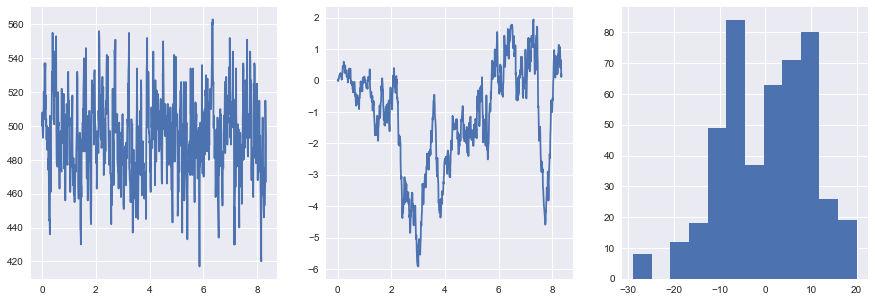

In [249]:
test_realisation = test_sim.realisations[0]
test_time = test_realisation[FIELD_TIME]
test_agent_n = test_realisation[FIELD_AGENT_COORDS]
test_population_size_n = map(len, test_agent_n)
test_mean_n = map(np.mean, test_agent_n)
fig_test, ax_test = plt.subplots(1, 3, figsize=(15, 5))
ax_test[0].plot(test_time, test_population_size_n)
ax_test[1].plot(test_time, test_mean_n)
x = ax_test[2].hist(test_agent_n[-1], bins=utils.compute_bins(np.array(test_agent_n[-1])))

In [210]:
print test_population_size_n[-100:]
print test_time[-100:]
print len(test_time)

[359, 341, 323, 306, 322, 339, 356, 338, 355, 373, 354, 372, 353, 371, 390, 410, 431, 409, 388, 368, 387, 407, 386, 366, 385, 365, 384, 404, 425, 403, 382, 402, 423, 401, 422, 400, 420, 399, 379, 398, 378, 359, 341, 359, 377, 358, 340, 323, 340, 357, 375, 394, 374, 393, 413, 392, 372, 391, 371, 352, 370, 389, 369, 388, 368, 387, 407, 386, 406, 385, 405, 384, 404, 383, 363, 344, 362, 381, 361, 380, 361, 380, 361, 342, 324, 307, 323, 340, 357, 375, 394, 374, 355, 373, 392, 372, 353, 371, 352, 334]
[64.237292360252283, 64.237922068900346, 64.23856209799159, 64.239219814098576, 64.240554565486036, 64.251605607971328, 64.263693730988876, 64.266826626285152, 64.278647976078503, 64.290087084210938, 64.295215008077292, 64.306378001254814, 64.309053520812924, 64.320475669798114, 64.331482749420758, 64.343618196251001, 64.354842217644048, 64.355702745370039, 64.35915978314101, 64.36105930588333, 64.37330737016714, 64.38560750441232, 64.395374947750867, 64.400089804307072, 64.411765086577091, 64.

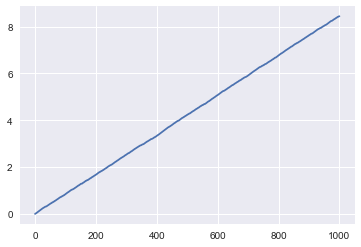

In [238]:
plt.plot(test_time)